In [12]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf
from tensorflow.keras.layers import Input
tf.__version__

'2.14.0'

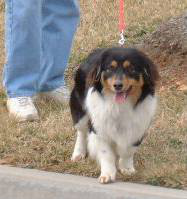

In [4]:
tf.keras.preprocessing.image.load_img('cat_dog_2\\training_set\dog\dog.2.jpg')

In [5]:
training_generator = ImageDataGenerator(rescale=1. / 255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)

train_dataset = training_generator.flow_from_directory('cat_dog_2\\training_set',
                                                        target_size=(256, 256),
                                                        batch_size=8,
                                                        class_mode='categorical',
                                                        shuffle=True)

Found 4000 images belonging to 2 classes.


In [6]:
test_generator = ImageDataGenerator(rescale=1. / 255)

test_dataset = test_generator.flow_from_directory('cat_dog_2\\test_set',
                                                  target_size=(256, 256),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1000 images belonging to 2 classes.


# Make Model

In [14]:
base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                            include_top=False,
                                            input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 5s 0us/step


In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [17]:
len(base_model.layers)

175

In [18]:
for layer in base_model.layers:
    layer.trainable = False

## Custom Dense Layer

In [19]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [21]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model =  Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [28]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_6')>

In [26]:
head_model

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_2')>

In [25]:
network = Model(inputs=base_model.input, outputs=head_model)

In [29]:
network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Train Model

In [31]:
network.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
500/500 [==============================] - 662s 1s/step - loss: 0.7295 - accuracy: 0.5397
Epoch 2/50
500/500 [==============================] - 1453s 3s/step - loss: 0.6863 - accuracy: 0.5445
Epoch 3/50
500/500 [==============================] - 556s 1s/step - loss: 0.6825 - accuracy: 0.5523
Epoch 4/50
500/500 [==============================] - 558s 1s/step - loss: 0.6786 - accuracy: 0.5585
Epoch 5/50
500/500 [==============================] - 580s 1s/step - loss: 0.6732 - accuracy: 0.5853
Epoch 6/50
500/500 [==============================] - 555s 1s/step - loss: 0.6705 - accuracy: 0.5882
Epoch 7/50
500/500 [==============================] - 554s 1s/step - loss: 0.6729 - accuracy: 0.5867
Epoch 8/50
500/500 [==============================] - 12440s 25s/step - loss: 0.6705 - accuracy: 0.5875
Epoch 9/50
500/500 [==============================] - 444s 887ms/step - loss: 0.6729 - accuracy: 0.5863
Epoch 10/50
500/500 [==============================] - 442s 884ms/step - loss: 0.673

KeyboardInterrupt: 

## Evaluate Model

In [ ]:
test_dataset.classes

In [ ]:
predictions = network.predict(test_dataset)
predictions

In [ ]:
test_dataset.class_indices

In [ ]:
prediction = np.argmax(predictions, axis=1)
prediction

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(test_dataset.classes, predictions)

In [ ]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [ ]:
print( classification_report(test_dataset.classes, predictions) )

## Fine Tuning

In [33]:
base_model.trainable = True
(base_model.layers)

In [34]:
fine_tune_at = 140

In [35]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [36]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
500/500 [==============================] - 851s 2s/step - loss: 0.7894 - accuracy: 0.5675
Epoch 2/50
500/500 [==============================] - 792s 2s/step - loss: 0.6578 - accuracy: 0.6125
Epoch 3/50
500/500 [==============================] - 793s 2s/step - loss: 0.6351 - accuracy: 0.6472
Epoch 4/50
428/500 [========================>.....] - ETA: 11:20 - loss: 0.6127 - accuracy: 0.6706

KeyboardInterrupt: 

## Evaluate FineTuned Model

In [ ]:
predictions = network.predict(test_dataset)
predictions

In [ ]:
predictions = np.argmax(predictions, axis=1)
predictions

In [ ]:
accuracy_score(test_dataset.classes, predictions)

In [ ]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [ ]:
print( classification_report(test_dataset.classes, predictions) )

## Save Weights

In [ ]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [ ]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

## Classift Image